*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). April 2020.*

## Tutorial N6. Coupler Kick.
*Second order tracking with coupler kick in TESLA type cavity of the 200k particles.*

As an example, we will use linac L1 of the European XFEL accelerator. 


The input coupler and the higher order mode couplers of the RF cavities distort the axial symmetry of the electromagnetic (EM) field and affect the electron beam. This effect can be calculated by direct tracking of the particles in the asymmetric (due to the couplers) 3D EM field using a tracking code (e.g. ASTRA). For fast estimation of the coupler effect a discrete coupler model (as described, for example in [M. Dohlus et al, Coupler Kick for Very Short Bunches and its Compensation, Proc. of EPAC08, MOPP013](http://accelconf.web.cern.ch/AccelConf/e08/papers/mopp013.pdf) or [T.Hellert and M.Dohlus, Detuning related coupler kick variation of a superconducting nine-cell 1.3 GHz cavity](https://arxiv.org/pdf/1804.02487.pdf)) was implemented in OCELOT. Coefficients for 1.3 GHz modules are given in [M.Dohlus, Effects of RF coupler kicks in L1 of EXFEL](http://www.desy.de/fel-beam/s2e/talks/2017_02_07/martin.pdf). The 1st order part of the model includes time and offset dependency; the offset dependency has a skew component. To include effect of all couplers, the kicks are applied at the entrance and the exit of each cavity. 

The zeroth and first order kick $\vec k$ on a bunch induced by a coupler can be expressed as

\begin{equation} 
\vec k(x, y) \approx \frac{eV_0}{E_0} \Re \left\{ \left( 
\begin{matrix}
V_{x0}\\
V_{y0}
\end{matrix} \right) + \left( 
\begin{matrix}
    V_{xx} & V_{xy} \\
    V_{yx} & V_{yy}
\end{matrix}\right)
\left( 
\begin{matrix}
x\\
y
\end{matrix} \right) e^{i \phi}\right\}
\end{equation}

with $E_0$ being the beam energy at the corresponding coupler region, $V_0$ and $\phi$ the amplitude and phase of the accelerating field, respectively, $e$ the elementary charge and $x$ and $y$ the transverse beam position at the coupler location. From Maxwell equations it follows that $V_{yy} = −V_{xx}$ and $V_{xy} = V_{yx}$. Thus, coupler kicks are up to first order well described with four normalized coupler kick coefficients $[V_{0x}, V_{0y}, V_{xx}, V_{xy}]$.


In OCELOT one can define copler kick coefficients for upstream and downstream coplers. 

```python

Cavity(l=0., v=0., phi=0., freq=0., vx_up=0, vy_up=0, vxx_up=0, vxy_up=0,
                 vx_down=0, vy_down=0, vxx_down=0, vxy_down=0, eid=None)

```

#### This example will cover the following topics:
* Defining the coupler coefficients for Cavity
* tracking of second order with Coupler Kick effect.

### Details of implementation in the code
*New in version 20.04.0*

The coupler kicks are implemented in the code the same way as it was done for ```Edge``` elements. At the moment of inizialisation of ```MagneticLattice``` around ```Cavity``` element are created elemnents ```CouplerKick```, the coupler kick before ```Cavity``` use coefficents with suffix "_up" (upstream) and after ```Cavity``` is placed ```CouplerKick``` with coefficent "_down" (downstream). The Coupler Kick elements are created even though coupler kick coefficennts are zeros. 

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it

%matplotlib inline

from time import time 

# this python library provides generic shallow (copy) 
# and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot main modules and functions
from ocelot import *
# extra function to track the Particle though a lattice
from ocelot.cpbd.track import lattice_track

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# import lattice
from xfel_l1 import *

initializing ocelot...


In [2]:
tws0 = Twiss()
tws0.E = 0.005

tws0.beta_x  = 7.03383607232
tws0.beta_y  = 4.83025657816
tws0.alpha_x = 0.981680481977
tws0.alpha_y = -0.524776086698
tws0.E       = 0.1300000928

lat = MagneticLattice(cell_l1, start=bpmf_103_i1, stop=qd_210_b1)

# twiss parameters without coupler kick
tws1 = twiss(lat, tws0)

# adding coupler coefficients in [1/m]
for elem in lat.sequence:
    if elem.__class__ == Cavity:
        if not(".AH1." in elem.id):
            # 1.3 GHz cavities
            elem.vx_up = (-56.813 + 10.751j) * 1e-6
            elem.vy_up = (-41.091 + 0.5739j) * 1e-6
            elem.vxx_up = (0.99943 - 0.81401j) * 1e-3
            elem.vxy_up = (3.4065 - 0.4146j) * 1e-3
            elem.vx_down = (-24.014 + 12.492j) * 1e-6
            elem.vy_down = (36.481 +  7.9888j) * 1e-6
            elem.vxx_down = (-4.057 - 0.1369j) * 1e-3
            elem.vxy_down = (2.9243 - 0.012891j) * 1e-3
        else:
            # AH1 cavity (3.9 GHz) module names are 'C3.AH1.1.1.I1', 'C3.AH1.1.2.I1', ...
            # Modules with odd and even number X 'C3.AH1.1.X.I1' have different coefficients
            
            module_number = float(elem.id.split(".")[-2])
            
            if module_number % 2 == 1:

                elem.vx_up = -0.00057076 - 1.3166e-05j
                elem.vy_up = -3.5079e-05 + 0.00012636j
                elem.vxx_up = -0.026045 - 0.042918j
                elem.vxy_up = 0.0055553 - 0.023455j

                elem.vx_down = -8.8766e-05 - 0.00024852j
                elem.vy_down = 2.9889e-05 + 0.00014486j
                elem.vxx_down = -0.0050593 - 0.013491j
                elem.vxy_down = 0.0051488 + 0.024771j
            else:

                elem.vx_up = 0.00057076 + 1.3166e-05j
                elem.vy_up = 3.5079e-05 - 0.00012636j
                elem.vxx_up = -0.026045 - 0.042918j
                elem.vxy_up = 0.0055553 - 0.023455j

                elem.vx_down = 8.8766e-05 + 0.00024852j
                elem.vy_down = -2.9889e-05 - 0.00014486j
                elem.vxx_down = -0.0050593 - 0.013491j
                elem.vxy_down = 0.0051488 + 0.024771j

# update transfer maps
lat.update_transfer_maps()
tws = twiss(lat, tws0)

#### Twiss parameters with and without coupler kick

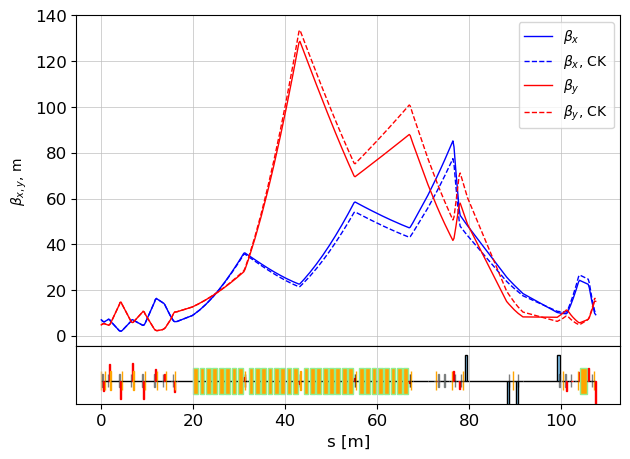

In [3]:
bx0 = [tw.beta_x for tw in tws1]
by0 = [tw.beta_y for tw in tws1]
s0 = [tw.s for tw in tws1]

bx = [tw.beta_x for tw in tws]
by = [tw.beta_y for tw in tws]
s = [tw.s for tw in tws]

fig, ax = plot_API(lat, legend=False)
ax.plot(s0, bx0, "b", lw=1, label=r"$\beta_x$")
ax.plot(s, bx, "b--", lw=1, label=r"$\beta_x$, CK")
ax.plot(s0, by0, "r", lw=1, label=r"$\beta_y$")
ax.plot(s, by, "r--", lw=1, label=r"$\beta_y$, CK")
ax.set_ylabel(r"$\beta_{x,y}$, m")
ax.legend()
plt.show()

#### Trajectories with Coupler Kick

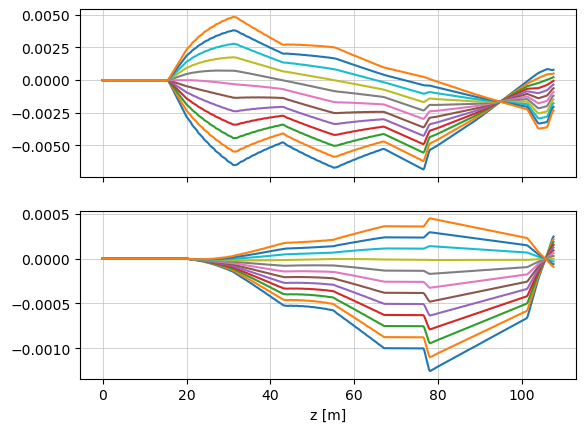

In [4]:
def plot_trajectories(lat):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    for a in np.arange(-0.6, 0.6, 0.1):
        cix_118_i1.angle = a*0.001
        lat.update_transfer_maps()
        p = Particle(px=0, E=0.130)
        plist = lattice_track(lat, p)
        s = [p.s for p in plist]
        x = [p.x for p in plist]
        y = [p.y for p in plist]
        px = [p.px for p in plist]
        py = [p.py for p in plist]
        ax1.plot(s, x)
        ax2.plot(s, y)
    plt.xlabel("z [m]")
    plt.show()
    
plot_trajectories(lat)

## Horizantal and vertical emittances
Before start we remove zero order terms (dipole kicks) from coupler kicks coefficients. 
And check if we have any asymmetry.

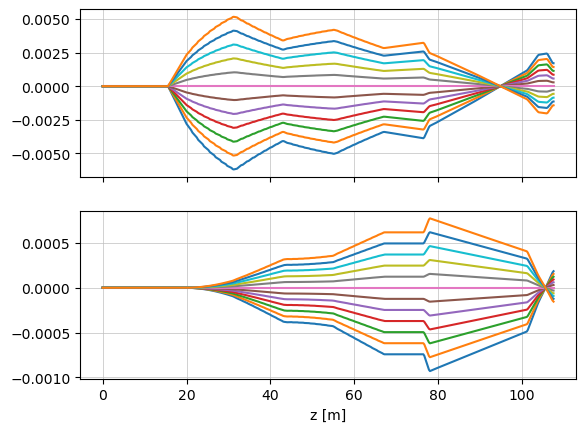

In [5]:
for elem in lat.sequence:
    if elem.__class__ == Cavity:
        if not(".AH1." in elem.id):
            # 1.3 GHz cavities
            elem.vx_up = 0.
            elem.vy_up = 0.
            elem.vxx_up = (0.99943 - 0.81401j) * 1e-3
            elem.vxy_up = (3.4065 - 0.4146j) * 1e-3
            elem.vx_down = 0.
            elem.vy_down = 0.
            elem.vxx_down = (-4.057 - 0.1369j) * 1e-3
            elem.vxy_down = (2.9243 - 0.012891j) * 1e-3

# update transfer maps
lat.update_transfer_maps()

# plot the trajectories 
plot_trajectories(lat)

### Tracking of the particles though lattice with coupler kicks
Steps:
* create ParticleArray with zero length and zero energy spread and chirp
* track the Particle array through the lattice
* plot the emittances

In [6]:
# create ParticleArray with "one clice"
parray = generate_parray(sigma_tau=0., sigma_p=0.0, chirp=0.0)
print(parray)

ParticleArray: 
Ref. energy : 0.13 GeV 
Ave. energy : 0.13 GeV 
std(x)      : 0.1 mm
std(px)     : 0.02 mrad
std(y)      : 0.1 mm
std(py)     : 0.02 mrad
std(p)      : 0.0
std(tau)    : 0.0 mm
Charge      : 5.0 nC 
s pos       : 0.0 m 
n particles : 200000



In [7]:
# track the beam though the lattice
navi = Navigator(lat)
tws_track, _ = track(lat, parray, navi)

z = 107.53222499999997 / 107.53222499999997. Applied:  

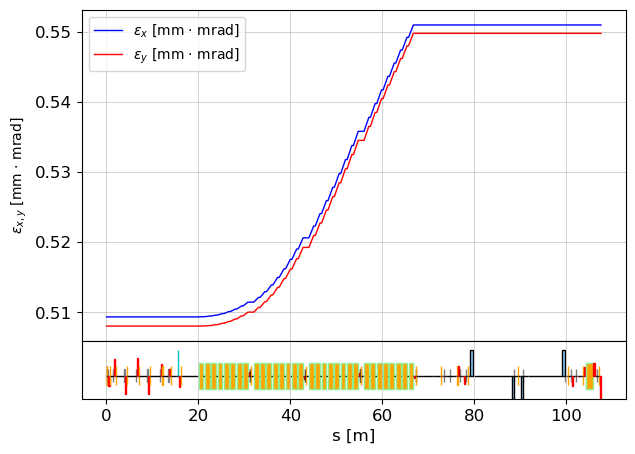

In [8]:
# plot emittances
emit_x = np.array([tw.emit_x for tw in tws_track])
emit_y = np.array([tw.emit_y for tw in tws_track])
gamma = np.array([tw.E for tw in tws_track])/m_e_GeV

s = [tw.s for tw in tws_track]

fig, ax = plot_API(lat, legend=False)
ax.plot(s, emit_x * gamma * 1e6, "b", lw=1, label=r"$\varepsilon_x$ [mm $\cdot$ mrad]")
ax.plot(s, emit_y * gamma * 1e6, "r", lw=1, label=r"$\varepsilon_y$ [mm $\cdot$ mrad]")
ax.set_ylabel(r"$\varepsilon_{x,y}$ [mm $\cdot$ mrad]")
ax.legend()
plt.show()

### Eigenemittance

As can we see, the projected emittances are not preserved, although all matrices are symplectic. The reason is the coupler kicks inroduce coupling between $X$ and $Y$ planes while the projected emittances are invariants under linear uncoupled (with respect to the laboratory coordinate system) symplectic transport. 

However, there are invariants under arbitrary (possibly coupled) linear symplectic transformations - eigenemittances.  Details can be found here [V. Balandin and N. Golubeva "Notes on Linear Theory of Coupled Particle Beams with Equal Eigenemittances"](https://s3.cern.ch/inspire-prod-files-a/a0b74ceb25bfb372d743c8227edfaf48) and [V.Balandin et al "Twiss Parameters of Coupled Particle Beams with Equal Eigenemittances"](https://arxiv.org/pdf/1205.3589.pdf)

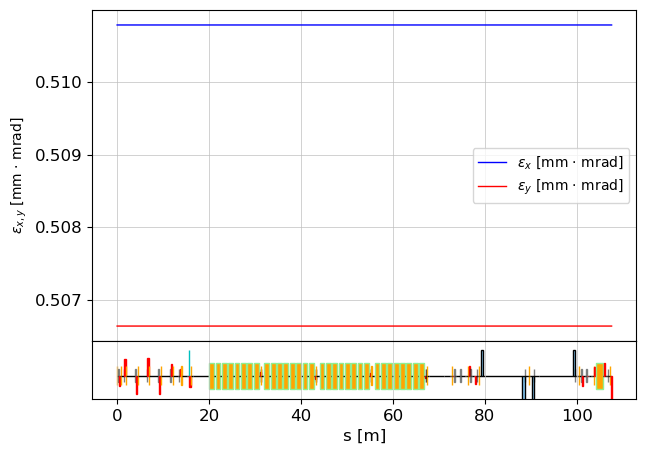

In [9]:
# plot emittances
emit_x = np.array([tw.eigemit_1 for tw in tws_track])
emit_y = np.array([tw.eigemit_2 for tw in tws_track])
gamma = np.array([tw.E for tw in tws_track])/m_e_GeV

s = [tw.s for tw in tws_track]

fig, ax = plot_API(lat, legend=False)
ax.plot(s, emit_x * gamma * 1e6, "b", lw=1, label=r"$\varepsilon_x$ [mm $\cdot$ mrad]")
ax.plot(s, emit_y * gamma * 1e6, "r", lw=1, label=r"$\varepsilon_y$ [mm $\cdot$ mrad]")
ax.set_ylabel(r"$\varepsilon_{x,y}$ [mm $\cdot$ mrad]")
ax.legend()
plt.show()